In [1]:
import sys; print('Python \t\t{0[0]}.{0[1]}'.format(sys.version_info))
import tensorflow as tf; print('Tensorflow \t{}'.format(tf.__version__))
import keras; print('Keras \t\t{}'.format(keras.__version__))


Python 		3.6
Tensorflow 	1.0.0


Using TensorFlow backend.


Keras 		2.0.3


In [2]:
%matplotlib inline 

from sys import stdout
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../mnist-data/", one_hot=True)

Extracting ../mnist-data/train-images-idx3-ubyte.gz
Extracting ../mnist-data/train-labels-idx1-ubyte.gz
Extracting ../mnist-data/t10k-images-idx3-ubyte.gz
Extracting ../mnist-data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.shape

(55000, 784)

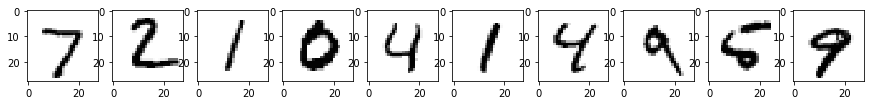

In [5]:
plt.figure(figsize=(15,5))
for i in list(range(10)):
    plt.subplot(1, 10, i+1)
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
plt.show()

In [6]:
import tensorflow as tf

In [7]:
# Set parameters
learning_rate = 0.01
training_iteration = 5
batch_size = 250
print_freq=1

In [8]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1, mean=0.0) #tf.constant(0.0, shape=shape)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [9]:
# TF graph input
x = tf.placeholder('float', [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder('float', [None, 10]) # 0-9 digits recognition => 10 classes

#dropout rate = 1 - keep_rate
keep_rate = tf.placeholder(tf.float32)

In [ ]:
# keras model for reference

# model = Sequential()
# model.add(Reshape(input_shape, input_shape=(784,)))

# model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
# model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D((2,2)))

# model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
# model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D((2,2)))

# model.add(Flatten())

# model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu'))

# model.add(Dropout(0.25))
# model.add(Dense(10, activation='softmax'))

In [14]:
def conv2d(name, x, weight, bias):
    with tf.name_scope(name) as scope:
        #filter definition
        f = weight_variable(weight)
        b = bias_variable(bias)
    
        # Construct a dense linear model, with act=relu and dropout
        y = tf.nn.relu(tf.nn.conv2d(input=x, filter=f, strides=[1,1,1,1], padding='SAME') +b)
        return y  

In [10]:
def conv2d_maxpool(name, x, d_in, d_out):
    # 2 conv layers stride 1,1 and maxpool maxpool strides of 2
    with tf.name_scope(name) as scope:
        c1 = conv2d("conv_1", x,  [3,3,d_in,d_out],  [d_out])
        c2 = conv2d("conv_2", c1, [3,3,d_out,d_out], [d_out])
        y = tf.nn.max_pool(value=c2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        return y

In [11]:
def dropout(name, x, keep_rate):
    with tf.name_scope(name) as scope:
        return tf.nn.dropout(x, keep_rate)

def dense(name, x, weight, bias, activation='linear'):
    with tf.name_scope(name) as scope:
        # Set model weights
        W = weight_variable(weight)
        b = bias_variable(bias)

        # Construct a dense linear model, with act=relu and dropout
        y = tf.matmul(x, W) + b  
        
        if activation=='relu':
            return tf.nn.relu(y)
        else:
            return y

### Define the network

In [12]:
with tf.name_scope("reshape") as scope:
    layer_0 = tf.reshape(x, [-1, 28, 28, 1])

In [15]:
layer_1 = conv2d_maxpool('CONV-3x3x32', layer_0, 1 , 32)
layer_2 = conv2d_maxpool('CONV-3x3x64', layer_1, 32, 64)

In [16]:
with tf.name_scope("flatten") as scope:
    layer_3 = tf.reshape(layer_2, [-1, 7*7*64])    

In [17]:
layer_4  = dropout("dropout", layer_3, keep_rate)
layer_5  = dense('dense_256', layer_4, [7*7*64,256], [256], 'relu')

layer_6  = dropout("dropout", layer_5, keep_rate)
layer_7  = dense('dense_10',  layer_6, [256,10], [10], 'linear')

### Cost functions and Training

In [18]:
# get the softmax as a separate tensorflow op
y_out = tf.nn.softmax(layer_7)

# softmax cross entropy descend on y_hat
y_hat = layer_7

# More name scopes will clean up graph representation
with tf.name_scope("cost_function") as scope:
    # Minimize error using cross entropy
    # Cross entropy
    cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_hat))
    
    # Create a summary to monitor the cost function
    tf.summary.scalar("cost_function", cost_function)

In [19]:
with tf.name_scope("train") as scope:
    # Gradient descent
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_function)

In [20]:
predictions = tf.equal(tf.argmax(y_out, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(predictions, "float"))

In [21]:
# Initializing the variables
init = tf.global_variables_initializer()

# Merge all summaries into a single operator
merged_summary_op = tf.summary.merge_all()

In [22]:
# Launch the graph
sess = tf.InteractiveSession()

# Logs and graph for tensorboard
summary_writer = tf.summary.FileWriter('./tensorboard/tf-rewrite', graph=sess.graph)

# Init the session
sess.run(init)

In [23]:
# Training cycle
for iteration in range(training_iteration):
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    avg_loss =0.
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        # dropout placeholder
        batch_kr = 0.75
        
        # Fit training using batch data
        loss, accuracy, optm = sess.run([cost_function,acc,optimizer], 
            feed_dict={x: batch_xs, keep_rate: batch_kr, y: batch_ys})
        
        avg_loss += loss
        
        stdout.write('\r{}/{} avg_cost:{:6f} cost:{:6f} acc:{:6f}'.format(i*batch_size, 
                                                                  mnist.train.num_examples, 
                                                                  avg_loss/(i+1), 
                                                                  loss, accuracy))
        stdout.flush() 
            
    # Display logs per iteration step
    if iteration % print_freq ==0 :
        accuracy_test = sess.run([acc], feed_dict={x: mnist.test.images, keep_rate: 1.0, y: mnist.test.labels})
        print(" epoch: {:02d} acc_test={:.9f}".format(iteration, accuracy_test[0]))


54750/55000 avg_cost:1.325054 cost:0.184887 acc:0.948000 epoch: 00 acc_test=0.958500028
29000/55000 avg_cost:0.194128 cost:0.228156 acc:0.944000

KeyboardInterrupt: 

In [ ]:
print("Accuracy:", acc.eval({x: mnist.test.images, keep_rate:1.0, y: mnist.test.labels}))

In [ ]:
# test item #100 is a six
pixels = mnist.test.images[100]

#predict
result = sess.run(y_out, feed_dict={x:[pixels], keep_rate:1.0})
dict(zip(range(10), result[0]))

In [ ]:
def test_render(pixels, result, truth):
    #pixels, result and truth are np vectors
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')

    plt.subplot(1, 2, 2)
    
    #index, witdh
    ind = np.arange(len(result))
    width = 0.4

    plt.barh(ind,result, width, color='gray')
    plt.barh(ind+width,truth,width, color='green')
    plt.yticks(ind+width, range(10))
    plt.margins(y=0)

    plt.show()

In [ ]:
import random
i = random.randint(0,mnist.test.images.shape[0])

pixels = mnist.test.images[i]
truth  = mnist.test.labels[i]
result = sess.run(y_out, feed_dict={x:[pixels], keep_rate:1.0})[0]

test_render(pixels, result, truth)

In [ ]:
### What went wrong?
pixels = mnist.test.images
truth = mnist.test.labels

feed_dict = {x:pixels,keep_rate:1.0}
result = sess.run(y_out, feed_dict=feed_dict)

In [ ]:
index_correct = result.argmax(axis=1) == truth.argmax(axis=1)
incorrect = np.argwhere(index_correct==False).flatten()

print("Incorrect predictions: {}".format(len(incorrect)))

In [ ]:
plt.figure(figsize=(20,5))
plt_idx = 1
for i in list(incorrect[:16]):
    plt.subplot(1, 16, plt_idx)
    pixels = mnist.test.images[i]
    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='gray_r')
    plt_idx += 1
plt.show()

In [ ]:
i = random.choice(list(incorrect))

pixels = mnist.test.images[i]
truth  = mnist.test.labels[i]

feed_dict = {x:[pixels]}
feed_dict.update({keep_rate:1.0})
result = sess.run(y_out, feed_dict=feed_dict)[0]

test_render(pixels, result, truth)

In [ ]:
# Close the Session when we're done.
sess.close()